In [13]:
#import google.cloud
from google.cloud import language_v1
import glob
import os
import pdfplumber
import jieba
import jieba.analyse
#import rake_nltk
from rake_nltk import Rake
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction import text
import pandas as pd
import pytesseract
from PIL import Image
import difflib
import re
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
from PyPDF2 import PdfReader


In [2]:
import sys
print(sys.executable)

/Users/emmiehine/Desktop/Research/WIPs/china_ai_ethics_principles_comp/china_ai_principles_txt/google_cloud_env/bin/python


In [26]:
# Path is path to directory containing file and results directory
# must have google_results dir made
def analyze_sentiment(fileName,pathToResults,lang):
    client = language_v1.LanguageServiceClient()
    text = open(fileName).read()
    document = language_v1.Document(content=text, type_=language_v1.Document.Type.PLAIN_TEXT)
    sentiment = client.analyze_sentiment(request={'document': document}).document_sentiment
    
    toUseName = fileName.split('/')[-1][:-4]
    doc = open(f'./{pathToResults}/{toUseName}_sent.txt','w')

    doc.write("Sentiment: {}, {}".format(sentiment.score, sentiment.magnitude))

    return [toUseName, str(sentiment.score), str(sentiment.magnitude)]

def analyze_entities(fileName, pathToResults, lang):
    client = language_v1.LanguageServiceClient()
    text = open(fileName).read()
    language = lang
    type_ = language_v1.Document.Type.PLAIN_TEXT
    document = {"content": text, "type_": type_, "language": language}

    # Available values: NONE, UTF8, UTF16, UTF32
    encoding_type = language_v1.EncodingType.UTF8

    response = client.analyze_entities(request = {'document': document, 'encoding_type': encoding_type})

    toUseName = fileName.split('/')[-1][:-4]
    
    doc = open(f'./{pathToResults}/{toUseName}_ent.txt','w')
    # Loop through entitites returned from the API
    for entity in response.entities:
        doc.write(u"Representative name for the entity: {}\n".format(entity.name))

        # Get entity type, e.g. PERSON, LOCATION, ADDRESS, NUMBER, et al
        doc.write(u"Entity type: {}\n".format(language_v1.Entity.Type(entity.type_).name))

        # Get the salience score associated with the entity in the [0, 1.0] range
        doc.write(u"Salience score: {}\n".format(entity.salience))

        # Loop over the metadata associated with entity. For many known entities,
        # the metadata is a Wikipedia URL (wikipedia_url) and Knowledge Graph MID (mid).
        # Some entity types may have additional metadata, e.g. ADDRESS entities
        # may have metadata for the address street_name, postal_code, et al.
        for metadata_name, metadata_value in entity.metadata.items():
            doc.write(u"{}: {}\n".format(metadata_name, metadata_value))

            # Loop over the mentions of this entity in the input document.
            # The API currently supports proper noun mentions.
        for mention in entity.mentions:
            doc.write(u"Mention text: {}\n".format(mention.text.content))

                # Get the mention type, e.g. PROPER for proper noun
            doc.write(u"Mention type: {}\n".format(language_v1.EntityMention.Type(mention.type_).name))
        doc.write('\n')
        # Get the language of the text, which will be the same as
        # the language specified in the request or, if not specified,
        # the automatically-detected language.
    doc.write(u"Language of the text: {}".format(response.language))        

def readPdf(path,name):
    write_file = open(f'{path}/{name}.txt','w')

    reader = PdfReader(f"{path}/{name}.pdf")
    num_pages = len(reader.pages)
    for i in range(0,num_pages):
        page = reader.pages[i]
        try: write_file.write(page.extract_text())
        except: write_file.write('')
    
#     page = reader.pages[0]
#     text = page.extract_text()

#     file = open(f'{path}/{name}.txt','w')
#     with pdfplumber.open(f"{path}/{name}.pdf") as pdf:
#         for page in pdf.pages:
#             try: file.write(page.extract_text(x_tolerance=3, y_tolerance=3))
#             except: file.write('')

    write_file.close()

# Sentiment Analysis

### China

In [24]:
def analyzeChSentiment(pathToText,pathToResults,csvName):
    fileNames = glob.glob(f'{pathToText}/*.txt')
    sentList = []
    for file in fileNames:
        print(f'analysing {file}')
        lang = ''
        if 'Ch' in file:
            lang = 'Zh'
        elif 'En' in file: # equitable programming
            lang = 'En'
        else:
            raise RuntimeError("Language could not be identified")

        sent = analyze_sentiment(file,pathToResults,lang)
        
        if lang == 'Zh':
            fileLen = len(re.sub('[。、，；：.,;:0-9]','', open(file).read()))
        else:
            fileLen = len(open(file).read().split(' '))
        print(fileLen)
        sent.append(fileLen)

        sentList.append(sent)
    print("done")
    df = pd.DataFrame(sentList,columns=['area','score','magnitude','file length'])
    df['score'] = pd.to_numeric(df['score'])
    df['magnitude'] = pd.to_numeric(df['magnitude'])
    df['mag/word'] = df['magnitude']/df['file length']
    df.to_csv(csvName,index=False)
    
def analyzeUSSentiments(pathToDocs,pathToResults,csvName):    
    sentList = []

    textFiles = glob.glob(f'{pathToDocs}/*.txt')

    for file in textFiles:
        print(f'analysing {file}')
        sent = analyze_sentiment(file,pathToResults,'en')
        analyze_entities(file,pathToResults,'en')
        fileLen = len(open(file).read().split(' '))

        sent.append(fileLen)    
        sentList.append(sent)
    print('done')
    df = pd.DataFrame(sentList,columns=['area','score','magnitude','word count'])
    
    df['score'] = pd.to_numeric(df['score'])
    df['magnitude'] = pd.to_numeric(df['magnitude'])
    df['mag/word'] = df['magnitude']/df['word count']
    df.to_csv(csvName,index=False)
    

In [10]:
analyzeChSentiment('./ethics_txts','sentiment_results/ch_results','ch_doc_sent.csv')


analysing ./txts/09_20_UNESCO_Ch.txt
24004
analysing ./txts/05_19_人工智能北京共识_Ch.txt
1252
analysing ./txts/06_19_新一代人工智能治理原则_Ch.txt
1024
analysing ./txts/10_22_中国关于加强人工智能伦理治理的立场文件_Ch.txt
1658
analysing ./txts/09_21_新一代人工智能伦理规范_Ch.txt
3088
analysing ./txts/09_20_UNESCO_III_Ch.txt
5503
done


In [78]:
analyzeChSentiment('./ch_laws_txts','sentiment_results/ch_results','ch_law_sent.csv')


analysing ./ch_laws/algo_draft_Ch.txt
3404
analysing ./ch_laws/genAI_draft_Ch.txt
2140
analysing ./ch_laws/synth_draft_Ch.txt
3373
analysing ./ch_laws/synth_final_Ch.txt
3217
analysing ./ch_laws/algo_final_Ch.txt
3893
analysing ./ch_laws/genAI_final_Ch.txt
3063
done


In [19]:
#analyzeChSentiment('./Chinese Local and Industry/text_files_no_attachments','./Chinese Local and Industry','ch_loc_sent_with_len_article.csv')



In [ ]:
# China local
# fileNames = glob.glob('./Chinese Local and Industry/Future Dev Plans/*.pdf')
# for file in fileNames:
#     path = file[:45]
#     name = file[46:-4]
#     readPdf(path,name)

### US

In [29]:
#Deal with PDFs
fileNames = glob.glob('./us_pdfs/*.pdf')

fileNames
for file in fileNames:
    path = file[:9]
    name = file[10:-4]
    readPdf(path,name)
    

['./us_pdfs/NAIRR_En.pdf',
 './us_pdfs/blueprint_En.pdf',
 './us_pdfs/AI_RMF_En.pdf',
 './us_pdfs/voluntary_commitments_En.pdf']

In [20]:
readPdf('./us_pdfs/','voluntary_commitments_En')

In [31]:
analyzeUSSentiments('./us_txts','sentiment_results/us_results','us_sentiments.csv')


analysing ./us_txts/AI_RMF_En.txt
analysing ./us_txts/CHIPS_2_En.txt
analysing ./us_txts/blueprint_En.txt
analysing ./us_txts/NAIRR_En.txt
analysing ./us_txts/EO_13985_En.txt
analysing ./us_txts/voluntary_commitments_En.txt
analysing ./us_txts/CHIPS_1_En.txt
done


# Text analysis

### Chinese

In [35]:
def extract_tags_Ch(file,dest_dir):
    path = '/'.join(file.split('/')[:-2])
    #print(path)
    name = file.split('/')[-1][:-4]
    text = open(file).read()
    analysis = jieba.analyse.extract_tags(text,topK=20,withWeight=True,allowPOS=())
    file = open(f'{path}/{dest_dir}/{name}_tags.csv','w')
    file.write('area')
    file.write(',')
    file.write('word')
    file.write(',')
    file.write('magnitude')
    file.write('\n')
    #file.write(str(analysis))
    for line in analysis:
        word = str(line).split(',')[0].replace('(','')
        mag = str(line).split(',')[1].replace(')','')
        
        file.write(name)
        file.write(',')
        file.write(word)
        file.write(',')
        file.write(mag)
        file.write('\n')
    file.close()

In [38]:
fileNames = glob.glob('./ethics_txts/*.txt')
print(len(fileNames))
for file in fileNames:
    print(file)
    extract_tags_Ch(file,'ch_tags')
print("Done")


Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/c3/5_s2f5kj5p19hx5_66tv9zcm0000gn/T/jieba.cache


6
./ethics_txts/09_20_UNESCO_Ch.txt


Loading model cost 0.525 seconds.
Prefix dict has been built successfully.


./ethics_txts/05_19_人工智能北京共识_Ch.txt
./ethics_txts/06_19_新一代人工智能治理原则_Ch.txt
./ethics_txts/10_22_中国关于加强人工智能伦理治理的立场文件_Ch.txt
./ethics_txts/09_21_新一代人工智能伦理规范_Ch.txt
./ethics_txts/09_20_UNESCO_III_Ch.txt
Done


In [79]:
fileNames = glob.glob('./ch_laws_txts/*.txt')
print(len(fileNames))
for file in fileNames:
    print(file)
    extract_tags_Ch(file,'ch_tags')
print("Done")

6
./ch_laws_txts/algo_draft_Ch.txt
./ch_laws_txts/genAI_draft_Ch.txt
./ch_laws_txts/synth_draft_Ch.txt
./ch_laws_txts/synth_final_Ch.txt
./ch_laws_txts/algo_final_Ch.txt
./ch_laws_txts/genAI_final_Ch.txt
Done


### English

In [ ]:
# Extracting tf-idf tags

In [47]:
def extract_tags_En(file):
    # stop_words = text.ENGLISH_STOP_WORDS
    name = file.split('/')[-1][:-4]
    read = open(file).read()
    
    splitDoc = read.split('.')
    tfIdfVectorizer=TfidfVectorizer(stop_words='english',use_idf=True)
    tfIdf = tfIdfVectorizer.fit_transform(splitDoc)
    df = pd.DataFrame(tfIdf[0].T.todense(), index=tfIdfVectorizer.get_feature_names_out(), columns=["TF-IDF"])
    df = df.sort_values('TF-IDF', ascending=False)
    df['area'] = name
    df['word'] = df.index
    df = df.reset_index()
    df[:20].to_csv(f'./us_tags/{name}_tags.csv')
    
    

In [48]:
textFiles = glob.glob('./us_txts/*.txt')
textFiles.remove('./us_txts/CHIPS_2_En.txt')
textFiles.remove('./us_txts/CHIPS_1_En.txt')

for file in textFiles:
    print(f"extracting {file}")
    extract_tags_En(file)

extracting ./us_txts/AI_RMF_En.txt
extracting ./us_txts/blueprint_En.txt
extracting ./us_txts/NAIRR_En.txt
extracting ./us_txts/EO_13985_En.txt
extracting ./us_txts/chips_act_full_En.txt
extracting ./us_txts/voluntary_commitments_En.txt


### Dealing with images

In [15]:
pytesseract.pytesseract.tesseract_cmd = r'/usr/local/Cellar/tesseract/4.1.1/bin/tesseract'

cdWrite = open('./Chinese Local and Industry/text_files/Chengdu_20_Ch.txt','w')
for i in range(1,21):
    text = pytesseract.image_to_string(Image.open(f'./Chengdu/p{i}.jpg'),lang='chi_sim').split('\n')
    newText = []
    for line in text:
        newLine = line.replace(' ','')
        newText.append(newLine)
    cdWrite.write('\n'.join(newText))
print("Done")
cdWrite.close()


Done


In [17]:
for i in range(1,7):
    print(f"PIC {i}")
    text = pytesseract.image_to_string(Image.open(f'./Anhui/b{i}.png'),lang='chi_sim').split('\n')
    newText = []
    for line in text:
        newLine = line.replace(' ','')
        newText.append(newLine)
    print('\n'.join(newText))
print("Done")
cdWrite.close()

PIC 1
表1人工智皑一发展主要目征

E中朝远明
(82020(82025(晓2030

产业规模(交值)
(元)

(伟倩)(仪元)



PIC 2
一招|基S68i许穿和关振兰央吴工振

[公|

八英醒能计筠理许、研究兴荣居知、八药孙习、娄院训机制计算
EsgspuS323332723

坤子筠邢认筠理、探素胺介知的量子林吊与内在认闽、矾穿坤子督
膨模坦租葛法、荣性育闵t:答的量子人工督邢处理洁、司与外晓江水互
信怡的宏时量子人工眼胺英

目胺河唐与自炎浩竹理解,许究基于河学习的新一代浩音合成语
口R刑、诊目文井、自佩国目理胺新方河

大玲荣脱理训、认亢基于数振技动与知训引吴经的的人工目院斧

亨础方江、英于敌技6述用人工真脱政孝班与途。
木e计算扔视免、研完基于洁度学习的i算扔祖克新方法,重帕砂宏生物

牺[R罚30视英、祖颂分忻与江理的理汞积新广法-

答深伟尿i前理it,矶交葛院伟伟一表征林5iRi2玟-
知伟国浩的踊与学习知论演化与振述、着胺渡泓与生颂葛技不,开江筠
E

闻绘机颜学习理论、研窃约计学习与河学习塔动浩论、不理定伯深
理不大精分布顺学习不交旯小根李学习、深医浑[学史无益督/医
月学习主动孙乙莲积根



自主无人系统的善能炜术、研究无人机自主挂制、沃车自动喜省、蝎
务机颜人髯育工门公人乐日技不

PIC 3
E
接不

庞技颂交咤胺浩模技木,训交虚扬扬标眼胺行加的政学志达丧模片
法,虚扬象、虚报异塌命用户之闭泓行自陆、挂继、深人交五扬

督胺汀筠芸片与系纬、重希交玲家胺故、史量白关陈芸片,佐功耕高
性腐芸片,研发其有自主学习能力的家放关胺神经门绍弯抵和硫伊系
统。构藏堤于FPGA的人工商酮不尿芸片及系红方容,系统性胺功根比优
E

人工葛郎于限务、砂究于颗生的秒澈学习和浩度孙习技术、提佳丫伯
化司宏刹人巯腐服务的云颜务伟系院扰的额务交井技术支荣侠途学习
模玲的莲与MHS80政河文沥不-

督胺史空斧许任根技李,以席央着胺史穸贺行业痛希积探用户
体驿为排向,砂江吴有应用深广仇僧的符胺史宇颜沙备余加耕沥不、通达
英余电浩邹的仁化、着能化酥雷传居国状忘、贺法仁和驱动优籁技札
刑江友纠汪用红红圆一伟化的觞大家。

算胺讥颜人关理技札,西向非性化摸作异溥下的洁动秦助玲断城
机阔人系的,研穿开仪式、数招关学、商有辽绍计算拳门的途用玲机渡人


In [20]:
readPdf('Chinese Local and Industry','DongguanCity')

# Diffs

In [7]:
chTextFiles = glob.glob('./Chinese Local and Industry/text_files_no_attachments/*_Ch.txt')
tYPText = open('./Chinese National/text_files/3_year_18-20_Ch.txt').read().replace('\u3000','')
d = difflib.Differ()

toRemove = ['\u3000','\n','、',',','(',')',
             ' ','-','/','+','（','）','《','》','\t','$',
            '&','*','~','～','%','%','<','>','@','[',']','{','}','|','\\',
            '_','=','\"','\“','\”','′','〈','〉','「','〔','〕',
            '“','”','①','②','③','④','⑤','＋','－','．','／','％']
for c in toRemove:
    tYPText = tYPText.replace(c,'')
split_tYP = re.split('[，。：:；;\n]',tYPText)
split_tYP = [x.replace('\n','') for x in split_tYP] # redundant?

matchDict = {}

for file in chTextFiles:
    name = file.split('/')[-1][:-4]
    text = open(file).read()
    for c in toRemove:
        text = text.replace(c,'')
        
    split_text = re.split('[,，.。：:；;\n]', text)
    
    to_write = open(f'./Chinese Local and Industry/diffs_new/{name}_diffs_punc_removed_article.txt','w')
    
    for phrase in split_text:
        #print(phrase)
        if phrase != '':
            phrase.replace('\n','')
            matches = difflib.get_close_matches(phrase, split_tYP, cutoff=0.7)
            if len(matches) > 0:
                to_write.write(f'{phrase} matched to {matches}\n')
                for match in matches:
                    if match in matchDict:
                        matchDict[match] += 1
                    else: matchDict[match] = 1
    to_write.close()
pd.DataFrame.from_dict(matchDict,orient='index').to_csv('diff_match_freqs_punct_removed_article.csv')


In [8]:
diffFiles = glob.glob('./Chinese Local and Industry/diffs_new/*.txt')
for file in diffFiles:
    print(f'{file}: {len(open(file).read())}')
    print('done')

./Chinese Local and Industry/diffs_new/SuzhouCity_21_Ch_diffs_punc_removed_article.txt: 0
done
./Chinese Local and Industry/diffs_new/GuangxiAR_18_Ch_diffs_punc_removed_article.txt: 572
done
./Chinese Local and Industry/diffs_new/ShenzhenCity_19-23_Ch_diffs_punc_removed_article.txt: 1715
done
./Chinese Local and Industry/diffs_new/GuangzhouCity_20-22_Ch_diffs_punc_removed_article.txt: 357
done
./Chinese Local and Industry/diffs_new/Zhejiang_17-22_Ch_diffs_punc_removed_article.txt: 802
done
./Chinese Local and Industry/diffs_new/HangzhouCity_19_Ch_diffs_punc_removed_article.txt: 113
done
./Chinese Local and Industry/diffs_new/Gansu_18_Ch_diffs_punc_removed_article.txt: 594
done
./Chinese Local and Industry/diffs_new/Yunnan_19_Ch_diffs_punc_removed_article.txt: 1239
done
./Chinese Local and Industry/diffs_new/Heilongjiang_18-20_Ch_diffs_punc_removed_article.txt: 1421
done
./Chinese Local and Industry/diffs_new/Guangdong_18-20_Ch_diffs_punc_removed_article.txt: 758
done
./Chinese Local an

# Analyzing keywords

In [50]:
# Generate summary freqs and mags using tf-idf files

def analyseKeywords(files,outputName,col):
    freqs = {}
    mags = {}
    
    for file in files:
        df = pd.read_csv(file)
        words = df['word']
        mag = df[col]#['TF-IDF']
        for word,m in zip(words,mag):
            if word in freqs:
                freqs[word] += 1
            else:
                freqs[word] = 1
            if word in mags:
                mags[word] += m
            else:
                mags[word] = m

    freqDf = pd.DataFrame.from_dict(freqs,orient='index',columns=['freq'])
    magDf = pd.DataFrame.from_dict(mags,orient='index',columns=['mag'])
    freqDf = freqDf.merge(magDf,left_index=True,right_index=True)
    freqDf['avg_mag'] = freqDf['mag']/freqDf['freq']

    freqDf['total_freq'] = freqDf['freq']
    freqDf['freq'] = freqDf['freq']/len(files)
    freqDf.to_csv(outputName)

In [53]:
# enTagFiles = glob.glob('./Chinese Local and Industry/jieba_results/*_En_tags.csv')
# analyseKeywords(enTagFiles,'ch_local_translations_freqs_and_mags.csv','magnitude')
# chTagFiles = glob.glob('./ch_tags/*_Ch_tags.csv')
# analyseKeywords(chTagFiles,'ch_freqs_mags.csv','magnitude')


In [83]:
chLawFiles = [f for f in glob.glob('./ch_tags/*_Ch_tags.csv') if 'draft' in f or 'final' in f]#glob.glob(r'./ch_tags/*_(draft|final)_Ch.txt')
chLawFiles

['./ch_tags/algo_final_Ch_tags.csv',
 './ch_tags/synth_draft_Ch_tags.csv',
 './ch_tags/algo_draft_Ch_tags.csv',
 './ch_tags/synth_final_Ch_tags.csv',
 './ch_tags/genAI_draft_Ch_tags.csv',
 './ch_tags/genAI_final_Ch_tags.csv']

In [85]:
analyseKeywords(chLawFiles,'ch_laws_freqs_mags.csv','magnitude')

In [87]:
chEthicsFiles = [f for f in glob.glob('./ch_tags/*_Ch_tags.csv') if 'draft' not in f and 'final' not in f]
analyseKeywords(chEthicsFiles,'ch_ethics_freqs_mags.csv','magnitude')


In [92]:
chEthicsNoUN = [f for f in glob.glob('./ch_tags/*_Ch_tags.csv') if 'draft' not in f and 'final' not in f]
chEthicsNoUN.remove('./ch_tags/09_20_UNESCO_Ch_tags.csv')
chEthicsNoUN.remove('./ch_tags/09_20_UNESCO_III_Ch_tags.csv')
analyseKeywords(chEthicsNoUN,'ch_ethics_no_UN_freqs_mags.csv','magnitude')


In [54]:
usaTagFiles = glob.glob('./us_tags/*.csv')
analyseKeywords(usaTagFiles,'us_freqs_mags.csv','TF-IDF')

In [90]:
chEthicsNoUN

['./ch_tags/05_19_人工智能北京共识_Ch_tags.csv',
 './ch_tags/10_22_中国关于加强人工智能伦理治理的立场文件_Ch_tags.csv',
 './ch_tags/09_21_新一代人工智能伦理规范_Ch_tags.csv',
 './ch_tags/09_20_UNESCO_III_Ch_tags.csv']

In [44]:
len(usaTagFiles)

16

### Word Freqs

In [57]:
chFiles = glob.glob('./ethics_txts/*_Ch.txt')
usFiles = glob.glob('./us_txts/*.txt')


In [64]:
usFiles

['./us_txts/AI_RMF_En.txt',
 './us_txts/CHIPS_2_En.txt',
 './us_txts/blueprint_En.txt',
 './us_txts/NAIRR_En.txt',
 './us_txts/EO_13985_En.txt',
 './us_txts/chips_act_full_En.txt',
 './us_txts/voluntary_commitments_En.txt',
 './us_txts/CHIPS_1_En.txt']

In [67]:
len('./us_txts/AI_RMF_En.txt'.split('/'))

3

In [74]:
def makeChFreqCSV(files,csvName,focusWords=[]):

    df = pd.DataFrame()
    dfList = []

    for file in files:
        text = open(file).read()
        split = file.split('/')
        name = split[len(split) - 1].split('_')[0]
        #test = test.replace('\u3000','').replace('\n','')

        toRemove = ['\u3000','\n',',','.',';',':','，','。','、',',','(',')',
                    ' ','：','-','/','+','（','）','《','》','；','\t','$',
                   '&','*','~','～','%','%','<','>','@','[',']','{','}','|','\\',
                   '_','=','\"','\“','\”','′','∶','〈','〉','「','〔','〕','?','？',
                   '“','”','①','②','③','④','⑤','＋','－','．','／','0','％']
        
        text = re.sub(r'[0-9]*','',text)

        #'（','）'
        for c in toRemove:
            text = text.replace(c,'')

        wordList = jieba.lcut(text,cut_all=False)
        wordDict = {}
        fullLen = len(wordList)

        for word in wordList:
            if (len(focusWords) > 0 and word in focusWords) or len(focusWords) == 0:
                if word in wordDict:
                    wordDict[word] += 1
                else:
                    wordDict[word] = 1

        #testDict
        wordDf = pd.DataFrame.from_dict(wordDict,orient='index',columns=[f'{name}_freq'])
        wordDf[f'{name}_pct'] = wordDf[f'{name}_freq']/fullLen*100
        dfList.append(wordDf)

        df = pd.merge(df,wordDf,how='outer',left_index=True,right_index=True)
 
    df.to_csv(csvName)
    print("Run complete.")

In [75]:
def makeEngFreqCSV(files,csvName,focusWords=[]):

    df = pd.DataFrame()
    dfList = []

    for file in files:
        text = open(file).read()
        split = file.split('/')
        name = split[len(split) - 1].split('.')[0]
       
        toRemove = ['\u3000','\n',',','.',';',':','，','。','、',',','(',')',
                    '：','-','/','+','（','）','《','》','；','\t','$',
                   '&','*','~','～','%','%','<','>','@','[',']','{','}','|','\\',
                   '_','=','\"','\“','\”','′','∶','〈','〉','「','〔','〕','?','？',
                   '“','”','①','②','③','④','⑤','＋','－','．','／','0','％','—',
                    '—','–','!','`','\'','•','’']
        
        text = re.sub(r'[0-9]*','',text)

        for c in toRemove:
            text = text.replace(c,'')

        wordList = text.lower().split(' ')
        wordDict = {}
        fullLen = len(wordList)
        
        if (len(focusWords) > 0):
            focusWords = [word.lower() for word in focusWords]

        for word in wordList:
            if (len(focusWords) > 0 and word in focusWords) or len(focusWords) == 0:
                if word in wordDict:
                    wordDict[word] += 1
                else:
                    wordDict[word] = 1

        wordDf = pd.DataFrame.from_dict(wordDict,orient='index',columns=[f'{name}_freq'])
        wordDf[f'{name}_pct'] = wordDf[f'{name}_freq']/fullLen*100
        dfList.append(wordDf)

        df = pd.merge(df,wordDf,how='outer',left_index=True,right_index=True)
        
    df.to_csv(csvName)
    print("Run complete.")
    

In [17]:
# makeChFreqCSV(localFiles,'ch_loc_US_mentions_article.csv',['美国'])

Run complete.


In [ ]:
# makeChFreqCSV(natChFiles,'ch_nat_US_mentions.csv',['美国'])

In [76]:
makeEngFreqCSV(usFiles,'us_nat_word_freqs.csv')

Run complete.


In [77]:
makeChFreqCSV(chFiles,'ch_nat_word_freqs.csv')

Run complete.


In [9]:
makeChFreqCSV(chiTagFilesNoIIDAP,'ch_nat_word_freqs_no_IIIDAP.csv')

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/c3/5_s2f5kj5p19hx5_66tv9zcm0000gn/T/jieba.cache
Loading model cost 1.269 seconds.
Prefix dict has been built successfully.


Run complete.


In [18]:
makeChFreqCSV(localFiles,'ch_local_word_freqs_article.csv')

Run complete.


In [16]:
# words = ['artificial','intelligence','copyright','innovation','innovate','industry','economy','united',
#         'states','executive','office','president','diversity','partnership','partnerships',
#         'ally','allies','america','american','initiative','ai','technology','application',
#         'promote','develop','development','application','apply','diverse','china','compete',
#          'competition','smart','future','work','economy','automation','security']
# makeEngFreqCSV(natUSFiles,'us_nat_focus_word_freqs_target_list_27-6.csv',words)


Run complete.


## Stat sig

In [31]:
def isStatSigUS(word,filename1,filename2):
    text1 = open(f"./American/docs/{filename1}.txt").read()
    text2 = open(f"./American/docs/{filename2}.txt").read()

    toRemove = ['\u3000','\n',',','.',';',':','，','。','、',',','(',')',
                '：','-','/','+','（','）','《','》','；','\t','$',
               '&','*','~','～','%','%','<','>','@','[',']','{','}','|','\\',
               '_','=','\"','\“','\”','′','∶','〈','〉','「','〔','〕','?','？',
               '“','”','①','②','③','④','⑤','＋','－','．','／','0','％','—',
                '—','–','!','`','\'','•','’']
        
    text1 = re.sub(r'[0-9]*','',text1)
    text2 = re.sub(r'[0-9]*','',text2)

    for c in toRemove:
        text1 = text1.replace(c,'')
        text2 = text2.replace(c,'')

    wordList1 = text1.lower().split(' ')
    len1 = len(wordList1)
    wordList2 = text2.lower().split(' ')
    len2 = len(wordList2)
    
    occs1 = wordList1.count(word)
    occs2 = wordList2.count(word)
    
    count = np.array([occs1,occs2])
    nobs = np.array([len1,len2])
    stat, pval = proportions_ztest(count, nobs)
    prop0=count[0]/nobs[0]
    prop1=count[1]/nobs[1]

    return (pval,prop0,prop1)


In [30]:
def statSigForList(wordList, file1, file2):
    listForDf = []
    for word in wordList:
        (val,prop0,prop1) = isStatSigUS(word, file1, file2)
        if prop1>prop0: direction = "increase"
        elif prop1<prop0: direction = "decrease"
        else: direction = "no change"
        listForDf.append([word,prop0,prop1,val,val<0.05,direction])
        
    df = pd.DataFrame.from_records(listForDf,columns=['word',file1,file2,'pval','isSig','direction'])
    return df

In [31]:
testDf = statSigForList(['american','diverse','industry','smart'],'national_ai_rd_strategic_plan','National-AI-RD-Strategy-2019')
display(testDf)

,word,pval,isSig
0,american,9.228449e-07,True
1,diverse,6.429622e-01,False
2,industry,2.066332e-01,False
3,smart,1.568761e-01,False


In [31]:
rdWordList = ['ai','artificial','development','diverse','executive',
              'president','privacy','research','science','security',
             'technology','accelerate','advance','america','american',
             'application','competition','data','develop','diversity',
             'economy','future','industry','innovation','lead','leadership','promote','partnership','partnerships',
             'rd','responsible','safe','safety','smart','strengthen','national',
             'support','system','talent','united','work']

rdDf = statSigForList(rdWordList,'national_ai_rd_strategic_plan','AI-Research-and-Development-Progress-Report-2016-2019')
display(rdDf[rdDf['isSig'] == True])
rdDf2 = statSigForList(rdWordList,'national_ai_rd_strategic_plan','National-AI-RD-Strategy-2019')
display(rdDf2[rdDf2['isSig'] == True])

,word,national_ai_rd_strategic_plan,AI-Research-and-Development-Progress-Report-2016-2019,pval,isSig,direction
0,ai,0.020761,0.014828,7.797514e-07,True,decrease
2,development,0.004003,0.002621,7.938448e-03,True,decrease
14,american,0.000047,0.000524,3.130008e-03,True,increase
17,data,0.004329,0.008051,3.475159e-07,True,increase
20,economy,0.000140,0.000562,1.716908e-02,True,increase
24,lead,0.000419,0.000112,3.398386e-02,True,decrease
25,leadership,0.000140,0.000487,3.761293e-02,True,increase
27,partnership,0.000000,0.000225,2.801479e-02,True,increase
28,partnerships,0.000000,0.000899,1.107833e-05,True,increase
35,national,0.005027,0.003370,4.702178e-03,True,decrease


,word,national_ai_rd_strategic_plan,National-AI-RD-Strategy-2019,pval,isSig,direction
2,development,0.004003,0.002345,9.255552e-04,True,decrease
7,research,0.008705,0.006502,4.711530e-03,True,decrease
10,technology,0.004422,0.002878,4.141724e-03,True,decrease
14,american,0.000047,0.001244,9.228449e-07,True,increase
23,innovation,0.000279,0.000853,1.001941e-02,True,increase
25,leadership,0.000140,0.000853,7.371182e-04,True,increase
28,partnerships,0.000000,0.001030,2.523450e-06,True,increase
29,rd,0.004282,0.008350,2.875917e-08,True,increase
37,system,0.003258,0.002238,2.942857e-02,True,decrease


In [33]:
rdDf3 = statSigForList(rdWordList,'trump_exec_order','DIVISION E--NATIONAL ARTIFICIAL INTELLIGENCE INITIATIVE ACT OF 2020 ')
display(rdDf3[rdDf3['isSig']==True])
rdDf4 = statSigForList(rdWordList,'trump_exec_order','HR153')
display(rdDf4[rdDf4['isSig']==True])
rdDf3.to_csv('rdDf3.csv')

/Users/emmiehine/anaconda3/lib/python3.6/site-packages/statsmodels/stats/weightstats.py:670: RuntimeWarning: invalid value encountered in double_scalars
  zstat = value / std_diff


,word,trump_exec_order,DIVISION E--NATIONAL ARTIFICIAL INTELLIGENCE INITIATIVE ACT OF 2020,pval,isSig,direction
0,ai,0.021726,0.000124,1.613677e-75,True,decrease
1,artificial,0.001468,0.012231,1.716812e-08,True,increase
4,executive,0.001174,0.000062,2.288935e-04,True,decrease
5,president,0.001762,0.000497,1.225466e-02,True,decrease
6,privacy,0.003230,0.000559,9.620836e-06,True,decrease
7,research,0.002349,0.007326,9.840038e-04,True,increase
8,science,0.001468,0.003849,3.087967e-02,True,increase
9,security,0.004110,0.001676,4.826475e-03,True,decrease
13,america,0.000294,0.000000,2.965888e-02,True,decrease
14,american,0.007634,0.000062,3.448477e-27,True,decrease


/Users/emmiehine/anaconda3/lib/python3.6/site-packages/statsmodels/stats/weightstats.py:670: RuntimeWarning: invalid value encountered in double_scalars
  zstat = value / std_diff


,word,trump_exec_order,HR153,pval,isSig,direction
1,artificial,0.001468,0.015385,0.000004,True,increase
2,development,0.004404,0.024615,0.000009,True,increase
3,diverse,0.000000,0.006154,0.000005,True,increase
21,future,0.000881,0.006154,0.013037,True,increase
30,responsible,0.000000,0.003077,0.001205,True,increase
31,safe,0.000294,0.006154,0.000369,True,increase
40,work,0.000000,0.003077,0.001205,True,increase


In [34]:
rdDf4.to_csv('rddf4.csv')

In [16]:
isStatSigUS('safety','national_ai_rd_strategic_plan','National-AI-RD-Strategy-2019')

national_ai_rd_strategic_plan: 0.0012102592747754038
National-AI-RD-Strategy-2019: 0.0013146207141588205
P-value for safety is: 0.7463056521396736
sorry.


In [17]:
top30PlusUS = ['artificial','intelligence','national','council','office',
               'development','technology','science','president','executive',
               'report','security','principal','enterprise','branch',
               'coordinates','means','chair','initiative','summary',
               'research','privacy','subcommittee','commission','entities',
               'diverse','ai','nstc','policy','options','organization',
               'organizations','original','output','outreach','omb','order'] 

usSuppWords = ['innovation','innovate','industry','economy','united','states',
         'diversity','partnership','partnerships',
        'ally','allies','america','american','application',
        'promote','develop','apply','china','compete',
         'competition','smart','future','work','economy','automation',
         'advance','accelerate','establish','develop','platform',
        'rd','sphere','support','data','demonstrate','wisdom','unit',
        'robot','robotic','service','cultivate','responsible','responsibility',
        'produce','lead','leadership','perception','scene','generation','talent',
        'make','safe','safety','internet','strengthen','system','mark','5G'] # from lower words and Chinese docs

s1 = set(top30PlusUS)
s2 = set(usSuppWords)
s1.intersection(s2)


set()

In [20]:
chWords = ['人工智能','智能','企业','发展','创新','应用','产业','支持',
           '技术','研发','制造','芯片','机器人','重点','领域','平台','产品',
           '建设','全球','人才','行业','设备','开展','打造','新','基础'] # independently identified

localTop30Plus = ['人工智能','应用','创新','智能','产业','发展','建设','技术','平台','领域',
                  '研发','企业','支持','数据','示范','智能化','智慧','机器人','单位','制造',
                  '加快','服务','一批','试验区','开展','责任','推进','培育','重点','新一代','人才']

s1 = set(localTop30Plus)
s2 = set(chWords)
s1.intersection(s2)
s3 = s2 - s1.intersection(s2)
locSuppWords = ['产品', '全球', '基础', '开展', '新', '芯片', '行业', '设备',
               '一批','人才', '制造', '加快', '单位', '培育', '感知', '打造', 
                '推进', '智慧', '构建', '牵头', '研究', '示范', '科技局','责任'] #s3 + diff between local and national
extraFromUS = ['经济', '多样', '合伙', '梦游', '美国', '中国', '我国', 
               '竞争', '竞赛', '未来', '工作', '自动', '自动化']

s3

#{'产品', '全球', '基础', '开展', '新', '芯片', '行业', '设备'}

{'产品', '全球', '基础', '打造', '新', '芯片', '行业', '设备'}

In [21]:
natTop29 = ['产业','应用','领域','人工智能','发展','创新','提升',
            '技术','建设','安全','智能','数据','平台','网络安全',
            '加强','体系','科技','智能化','支持','机器人','研发',
            '重点','系统','服务','工业','互联网','标识','企业','5G']
s1 = set(natTop29)
s2 = set(chWords)
s3 = s2 - s1.intersection(s2)
display(s3)
natSuppWords = ['产品', '人才', '全球', '制造', '基础', '开展', '打造', '新', '芯片', '行业', '设备',
               '一批','人才', '制造', '加快', '单位', '培育', '感知', '打造', 
                '推进', '智慧', '构建', '牵头', '研究', '示范', '科技局','责任'] # s3 plus local/national diff

{'产品', '人才', '全球', '制造', '基础', '开展', '打造', '新', '芯片', '行业', '设备'}

In [18]:
makeEngFreqCSV(natUSFiles,'us_top_words_freq_9-7.csv',top30PlusUS)
makeEngFreqCSV(natUSFiles,'us_supp_words_freq_9-7.csv',usSuppWords)


Run complete.
Run complete.


In [ ]:
makeChFreqCSV(natChFiles,'ch_nat_top_words_freq_18-5.csv',natTop29)
makeChFreqCSV(natChFiles,'ch_nat_supp_words_freq_18-5.csv',natSuppWords + extraFromUS)


In [22]:
makeChFreqCSV(localFiles,'ch_local_top_words_freq_article.csv',localTop30Plus)
makeChFreqCSV(localFiles,'ch_local_supp_words_freq_article.csv',locSuppWords + extraFromUS)

Run complete.
Run complete.


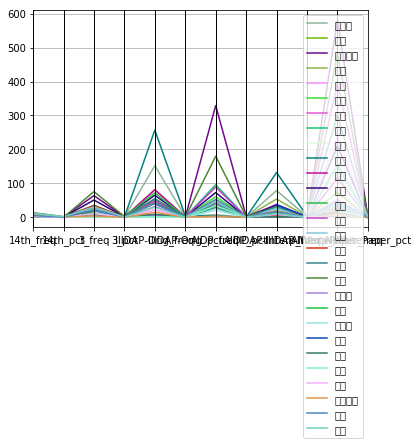

In [8]:
dfForPlot = pd.read_csv('./ch_nat_top_words_freq_18-5.csv')
pd.plotting.parallel_coordinates(dfForPlot,'Words')

In [11]:
rdDf = statSigForList(top30PlusUS + usSuppWords,'national_ai_rd_strategic_plan','AI-Research-and-Development-Progress-Report-2016-2019')
display(rdDf[rdDf['isSig'] == True])
rdDf2 = statSigForList(top30PlusUS + usSuppWords,'national_ai_rd_strategic_plan','National-AI-RD-Strategy-2019')
display(rdDf2[rdDf2['isSig'] == True])


/Users/emmiehine/anaconda3/lib/python3.6/site-packages/statsmodels/stats/weightstats.py:670: RuntimeWarning: invalid value encountered in double_scalars
  zstat = value / std_diff


,word,national_ai_rd_strategic_plan,AI-Research-and-Development-Progress-Report-2016-2019,pval,isSig,direction
2,national,0.005027,0.003370,4.702178e-03,True,decrease
5,development,0.004003,0.002621,7.938448e-03,True,decrease
10,report,0.000372,0.002696,4.729825e-10,True,increase
26,ai,0.020761,0.014828,7.797514e-07,True,decrease
40,economy,0.000140,0.000562,1.716908e-02,True,increase
44,partnership,0.000000,0.000225,2.801479e-02,True,increase
45,partnerships,0.000000,0.000899,1.107833e-05,True,increase
49,american,0.000047,0.000524,3.130008e-03,True,increase
60,economy,0.000140,0.000562,1.716908e-02,True,increase
70,data,0.004329,0.008051,3.475159e-07,True,increase


/Users/emmiehine/anaconda3/lib/python3.6/site-packages/statsmodels/stats/weightstats.py:670: RuntimeWarning: invalid value encountered in double_scalars
  zstat = value / std_diff


,word,national_ai_rd_strategic_plan,National-AI-RD-Strategy-2019,pval,isSig,direction
5,development,0.004003,0.002345,9.255552e-04,True,decrease
6,technology,0.004422,0.002878,4.141724e-03,True,decrease
14,branch,0.000233,0.000036,4.772064e-02,True,decrease
20,research,0.008705,0.006502,4.711530e-03,True,decrease
37,innovation,0.000279,0.000853,1.001941e-02,True,increase
45,partnerships,0.000000,0.001030,2.523450e-06,True,increase
49,american,0.000047,0.001244,9.228449e-07,True,increase
67,rd,0.004282,0.008350,2.875917e-08,True,increase
82,leadership,0.000140,0.000853,7.371182e-04,True,increase
92,system,0.003258,0.002238,2.942857e-02,True,decrease


In [12]:
rdDf3 = statSigForList(top30PlusUS + usSuppWords,'trump_exec_order','DIVISION E--NATIONAL ARTIFICIAL INTELLIGENCE INITIATIVE ACT OF 2020 ')
display(rdDf3[rdDf3['isSig']==True])
rdDf4 = statSigForList(top30PlusUS + usSuppWords,'trump_exec_order','HR153')
display(rdDf4[rdDf4['isSig']==True])

/Users/emmiehine/anaconda3/lib/python3.6/site-packages/statsmodels/stats/weightstats.py:670: RuntimeWarning: invalid value encountered in double_scalars
  zstat = value / std_diff


,word,trump_exec_order,DIVISION E--NATIONAL ARTIFICIAL INTELLIGENCE INITIATIVE ACT OF 2020,pval,isSig,direction
0,artificial,0.001468,0.012231,1.716812e-08,True,increase
1,intelligence,0.001762,0.012852,1.518960e-08,True,increase
3,council,0.001762,0.000124,1.797650e-05,True,decrease
7,science,0.001468,0.003849,3.087967e-02,True,increase
8,president,0.001762,0.000497,1.225466e-02,True,decrease
9,executive,0.001174,0.000062,2.288935e-04,True,decrease
11,security,0.004110,0.001676,4.826475e-03,True,decrease
13,enterprise,0.000294,0.000000,2.965888e-02,True,decrease
18,initiative,0.000881,0.002980,2.923889e-02,True,increase
20,research,0.002349,0.007326,9.840038e-04,True,increase


/Users/emmiehine/anaconda3/lib/python3.6/site-packages/statsmodels/stats/weightstats.py:670: RuntimeWarning: invalid value encountered in double_scalars
  zstat = value / std_diff


,word,trump_exec_order,HR153,pval,isSig,direction
0,artificial,0.001468,0.015385,0.000004,True,increase
1,intelligence,0.001762,0.009231,0.008725,True,increase
5,development,0.004404,0.024615,0.000009,True,increase
25,diverse,0.000000,0.006154,0.000005,True,increase
58,future,0.000881,0.006154,0.013037,True,increase
59,work,0.000000,0.003077,0.001205,True,increase
78,responsible,0.000000,0.003077,0.001205,True,increase
88,safe,0.000294,0.006154,0.000369,True,increase


### Re-doing diachronic analysis


In [41]:
usTopWords = ['artificial','intelligence','national','office','council','development',
'president','executive','technology','science','report','branch','principal','enterprise','means',
'coordinates','entities','security','ai','order','december','subcommittee','research','advancing',
'initiative','options','organization','organizations','original','output','outreach','chair','summary',
'commission','american','officers','officials','operate','diverse','make','policy','ordered','federal']

usSuppWords = ['innovation','innovate','industry','economy','united','states',
         'diversity','partnership','partnerships',
        'ally','allies','america','american','application',
        'promote','develop','apply','china','compete',
         'competition','smart','future','work','economy','automation',
         'advance','accelerate','establish','develop','platform',
        'rd','sphere','support','data','demonstrate','wisdom','unit','privacy',
        'robot','robotic','service','cultivate','responsible','responsibility',
        'produce','lead','leadership','perception','scene','generation','talent',
        'make','safe','safety','internet','strengthen','system','mark','5G'] 

# irrelevant now
rdWordList = ['ai','artificial','development','diverse','executive',
              'president','privacy','research','science','security',
             'technology','accelerate','advance','america','american',
             'application','competition','data','develop','diversity',
             'economy','future','industry','innovation','lead','leadership','promote','partnership','partnerships',
             'rd','responsible','safe','safety','smart','strengthen','national',
             'support','system','talent','united','work']

usTopSet = set(usTopWords)
usSuppSet = set(usSuppWords)
newSuppSet = usSuppSet - usTopSet

set(rdWordList) - (usTopSet | usSuppSet)

set()

In [43]:
rdDf = statSigForList(usTopWords + usSuppWords,'national_ai_rd_strategic_plan','AI-Research-and-Development-Progress-Report-2016-2019')
display(rdDf[rdDf['isSig'] == True])
rdDf.to_csv('aiRdSp-aiRdPR.csv')
rdDf2 = statSigForList(usTopWords + usSuppWords,'national_ai_rd_strategic_plan','National-AI-RD-Strategy-2019')
display(rdDf2[rdDf2['isSig'] == True])
rdDf2.to_csv('aiRdSp-aiRd19U.csv')


/Users/emmiehine/anaconda3/lib/python3.6/site-packages/statsmodels/stats/weightstats.py:670: RuntimeWarning: invalid value encountered in double_scalars
  zstat = value / std_diff


,word,national_ai_rd_strategic_plan,AI-Research-and-Development-Progress-Report-2016-2019,pval,isSig,direction
2,national,0.005027,0.003370,4.702178e-03,True,decrease
5,development,0.004003,0.002621,7.938448e-03,True,decrease
10,report,0.000372,0.002696,4.729825e-10,True,increase
18,ai,0.020761,0.014828,7.797514e-07,True,decrease
23,advancing,0.000326,0.002209,2.748485e-08,True,increase
34,american,0.000047,0.000524,3.130008e-03,True,increase
37,operate,0.000465,0.000000,4.216320e-04,True,decrease
42,federal,0.001722,0.003070,3.037716e-03,True,increase
46,economy,0.000140,0.000562,1.716908e-02,True,increase
50,partnership,0.000000,0.000225,2.801479e-02,True,increase


/Users/emmiehine/anaconda3/lib/python3.6/site-packages/statsmodels/stats/weightstats.py:670: RuntimeWarning: invalid value encountered in double_scalars
  zstat = value / std_diff


,word,national_ai_rd_strategic_plan,National-AI-RD-Strategy-2019,pval,isSig,direction
5,development,0.004003,0.002345,9.255552e-04,True,decrease
8,technology,0.004422,0.002878,4.141724e-03,True,decrease
11,branch,0.000233,0.000036,4.772064e-02,True,decrease
22,research,0.008705,0.006502,4.711530e-03,True,decrease
34,american,0.000047,0.001244,9.228449e-07,True,increase
42,federal,0.001722,0.002736,1.944553e-02,True,increase
43,innovation,0.000279,0.000853,1.001941e-02,True,increase
51,partnerships,0.000000,0.001030,2.523450e-06,True,increase
55,american,0.000047,0.001244,9.228449e-07,True,increase
73,rd,0.004282,0.008350,2.875917e-08,True,increase


In [59]:
rdDf3 = statSigForList(usTopWords + usSuppWords,'trump_exec_order','DIVISION E--NATIONAL ARTIFICIAL INTELLIGENCE INITIATIVE ACT OF 2020 ')
rdDf3.to_csv('tEO1-NAII.csv')
rdDf4 = statSigForList(usTopWords + usSuppWords,'trump_exec_order','HR153')
rdDf4.to_csv('tEO-HR153.csv')
rdDf5 = statSigForList(usTopWords + usSuppWords,'trump_exec_order','trump_eo_2_trustworthy')
rdDf5.to_csv('tEO1-tEO2.csv')

/Users/emmiehine/anaconda3/lib/python3.6/site-packages/statsmodels/stats/weightstats.py:670: RuntimeWarning: invalid value encountered in double_scalars
  zstat = value / std_diff


In [ ]:
makeEngFreqCSV(natUSFiles,'us_top_words_freq_9-7.csv',top30PlusUS)
makeEngFreqCSV(natUSFiles,'us_supp_words_freq_9-7.csv',usSuppWords)


In [48]:
natUSFiles.remove('./American/docs/nscai_full_2.txt')
natUSFiles.remove('./American/docs/nscai_full_1.txt')
natUSFiles

ValueError: list.remove(x): x not in list

In [49]:
natUSFiles

['./American/docs/AI-Research-and-Development-Progress-Report-2016-2019.txt',
 './American/docs/HR153.txt',
 './American/docs/AAII_one_year.txt',
 './American/docs/trump_exec_order.txt',
 './American/docs/national_ai_rd_strategic_plan.txt',
 './American/docs/ai_automation_economy_obama.txt',
 './American/docs/nist_ai_standards_fedengagement_plan_9aug2019.txt',
 './American/docs/DIVISION E--NATIONAL ARTIFICIAL INTELLIGENCE INITIATIVE ACT OF 2020 .txt',
 './American/docs/Guidance for Regulation of Artificial Intelligence Applications .txt',
 './American/docs/preparing_for_the_future_of_ai.txt',
 './American/docs/trump_eo_2_trustworthy.txt',
 './American/docs/advancing_american_AI_act.txt',
 './American/docs/SUMMARY-OF-DOD-AI-STRATEGY.txt',
 './American/docs/nscai_exec_summary.txt',
 './American/docs/National-AI-RD-Strategy-2019.txt',
 './American/docs/nscai_full_report.txt']

In [54]:
makeEngFreqCSV(natUSFiles,'us_top_words_freq_9-7.csv',usTopWords)
makeEngFreqCSV(natUSFiles,'us_supp_words_freq_9-7.csv',usSuppWords)

Run complete.
Run complete.


In [23]:
localTop30Plus = ['人工智能','应用','创新','智能','产业','发展','建设','技术','平台','领域',
                  '研发','企业','支持','数据','示范','智能化','智慧','机器人','单位','制造',
                  '加快','服务','一批','试验区','开展','责任','推进','培育','重点','新一代','人才']

locSuppWords = ['产品', '全球', '基础', '开展', '新', '芯片', '行业', '设备',
               '一批','人才', '制造', '加快', '单位', '培育', '感知', '打造', 
                '推进', '智慧', '构建', '牵头', '研究', '示范', '科技局','责任'] #s3 + diff between local and national
extraFromUS = ['经济', '多样', '合伙', '梦游', '美国', '中国', '我国', 
               '竞争', '竞赛', '未来', '工作', '自动', '自动化']

makeChFreqCSV(localFiles,'ch_local_top_words_freq_article.csv',localTop30Plus)
makeChFreqCSV(localFiles,'ch_local_supp_words_freq_article.csv',locSuppWords + extraFromUS)

Run complete.
Run complete.


In [58]:
# diff in terms/doc stat sig?
nobs = np.array([206,68])
count = np.array([16,6])
stat, pval = proportions_ztest(count, nobs)
print(stat)
print(pval)

-0.27799521422447276
0.7810160325119364
